In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Temp # Display row's columns and data for Measurement Table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x10a943198>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08}

In [11]:
# Temp # Display row's columns and data for Station Table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x10a943c18>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data 
# and plot the results

# Calculate the date 1 year ago from today
last_day = session.query(Measurement.date).\
order_by(Measurement.date.desc()).first()
last_day = last_day[0]
print(f"Last Day: {last_day}")

year_ago = dt.datetime(2017, 8, 23) - dt.timedelta(days=365)
print(f"Year Ago: {year_ago}")

Last Day: 2017-08-23
Year Ago: 2016-08-23 00:00:00


In [13]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date < dt.datetime(2017, 8, 23)).\
filter(Measurement.date > dt.datetime(2016, 8, 23)).all()

In [14]:
# Unpack 'date' and 'prcp_score' using list comprehensions
date = [result[0] for result in results]
prcp_score = [result[1] for result in results]

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.head(10)

,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13
2016-09-01,0.00


In [16]:
# Sort the dataframe by date
df = df.sort_values(['Date'])
df.head(10)

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
2016-08-24,1.22
2016-08-25,0.08
2016-08-25,0.00


<IPython.core.display.Javascript object>


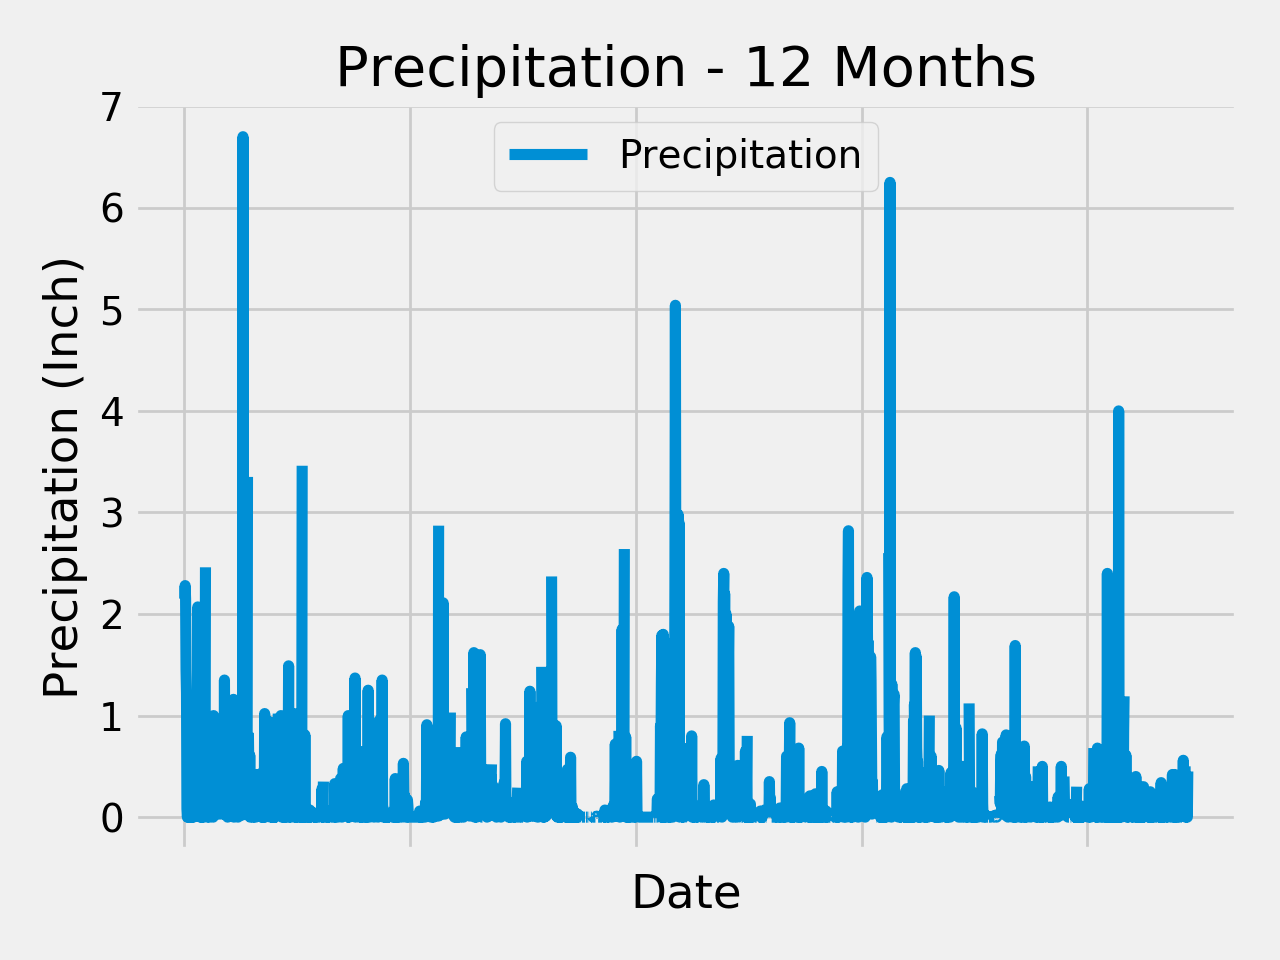

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

# Rotate the xticks for the dates
plt.title("Precipitation - 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inch)")
plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [19]:
# How many stations are available in this dataset?
stations = session.query(Station).count()
stations

9

In [20]:
# What are the most active stations?
# List the stations and the counts in descending order.
stations_activity = session.query(Station.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).filter(Station.station ==  Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()

stations_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_station = session.query(Measurement.station, func.min(Measurement.tobs), 
                               func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


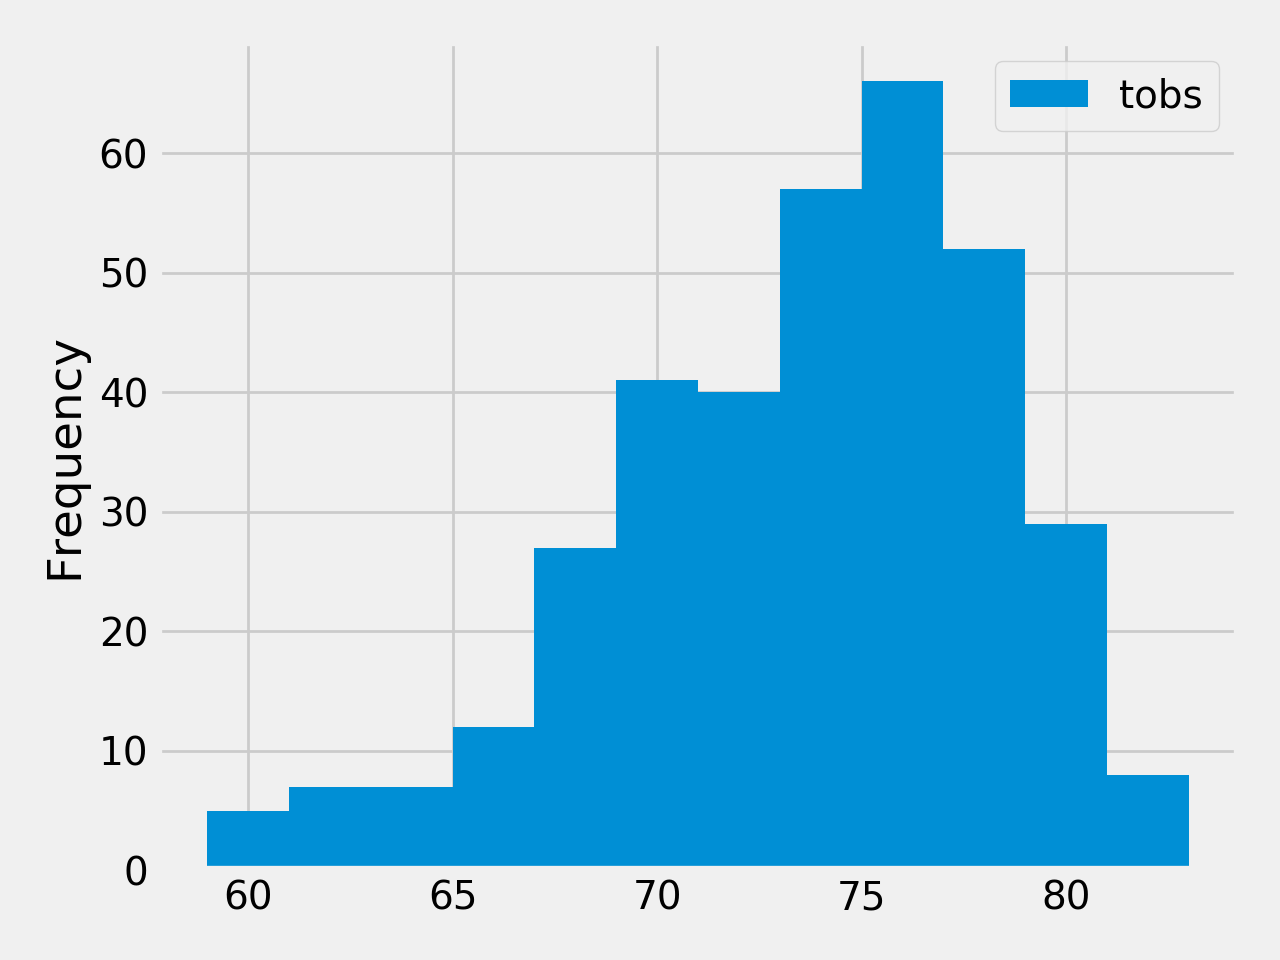

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date >= year_ago).\
filter(Measurement.station == 'USC00519281').all()
most_active

# Create DataFrame of tobs measurements
most_active_df = pd.DataFrame(most_active)
most_active_df.head()

# Plot Most Active Station Observations as Histogram
most_active_df.plot.hist("tobs", bins=12)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Temperature Analysis

In [23]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-08-23'
end_date = '2016-08-30'

vacay_query = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.date >= start_date).\
filter(Measurement.date <= end_date).all()

vacay_temp_df = pd.DataFrame(vacay_query, columns=['Date', 'Tobs'])
vacay_temp_df.head()

,Date,Tobs
0,2016-08-23,81.0
1,2016-08-24,79.0
2,2016-08-25,80.0
3,2016-08-26,79.0
4,2016-08-27,77.0


<IPython.core.display.Javascript object>


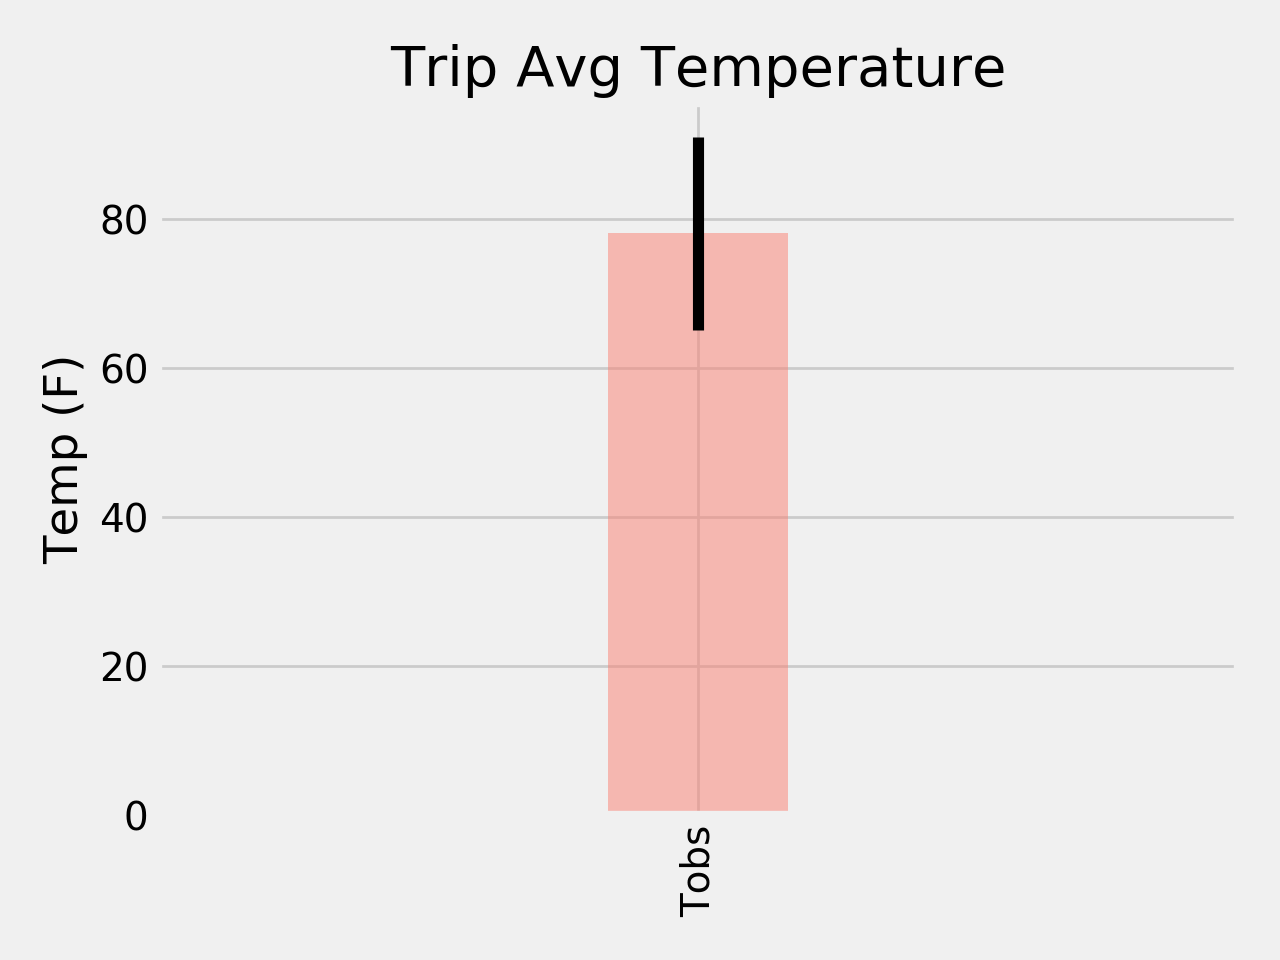

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = vacay_temp_df.mean()
temp_diff = (vacay_temp_df["Tobs"].max() - vacay_temp_df["Tobs"].min())

avg_temp.plot(kind="bar", color="salmon", yerr=temp_diff, alpha=.5, width=.1)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temperature')
plt.tight_layout()
plt.show()

In [26]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print (results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 5.28), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 5.079999999999999), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.9), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.55), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.5899999999999999), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.17), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06)]


## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-08-23'
end_date = '2016-08-30'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date, freq='D')

# Stip off the year and save a list of %m-%d strings
month_day_range = date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for date in month_day_range:
    normals.append(*daily_normals(date))

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norms_df = pd.DataFrame(normals, columns=['TMIN', "TAVG", "TMAX"])
norms_df['date'] = date_range
norms_df.set_index(['date'], inplace=True)
norms_df.head()

,TMIN,TAVG,TMAX
date,,,
2016-08-23,67.0,76.692308,87.0
2016-08-24,70.0,75.961538,84.0
2016-08-25,69.0,76.960784,82.0
2016-08-26,71.0,76.568627,84.0
2016-08-27,68.0,76.283019,84.0


<IPython.core.display.Javascript object>


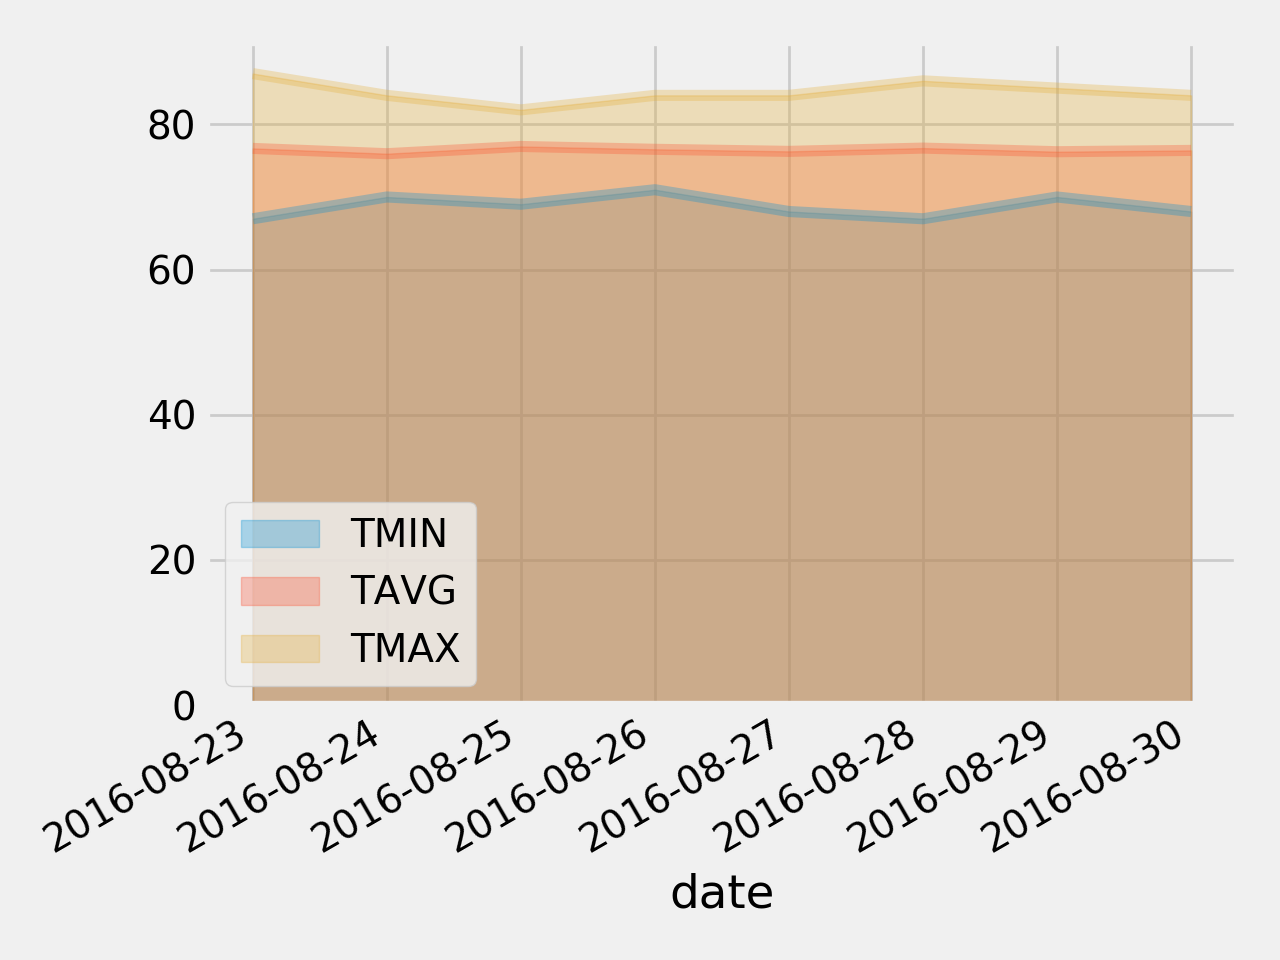

In [33]:
# Plot the daily normals as an area plot with `stacked=False`
norms_df.plot(kind='area', x_compat=True, alpha=.3, stacked=False)
plt.tight_layout()
plt.show()